# Homework 1 (October 18)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Описание задачи:

https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey

Даны 10000 наблюдений различных объектов с телескопа. Необходимо предсказать, является ли объект:

* звездой (класс `STAR`)
* галактикой (системой звезд) (класс `QALAXY`) 
* квазаром (сверхъярким астрономическим объектом, имеющим малые угловые размеры) (класс `QSO`)

Для каждого примера существует 17 признаков:
* `objid` - идентификатор фотометрических данных изображения
* `ra` (Right Ascension - прямое восхождение) - угол в системе координат, привязанной к Солнечной системе (аналог долготы)
* `dec` (declination) - аналогичный угол, аналог широты. Вместе `ra` и `dec` однозначно задают направление, с которого пришел сигнал
* `u, g, r, i, z` - сигналы в пяти частотных каналах телескопа
* `run, rerun, camcol, field` (run number, rerun number, camera column, field number) - параметры, описывающие изображение, захваченное телескопом. `run` описывает номер конкретного снимка (могут повторяться), `rerun` - постобработку, `camcol` - категориальный признак, означает положение снимка (камера снимает небо построчно; каждый `run` разбит на 6 параллельных строк), `field` - минимальная ячейка внутри `camcol` размером 10х13 угловых минут. Более подробно о том, как устроены изображения, можно прочитать тут:
https://www.sdss.org/dr12/imaging/imaging_basics/
* `specobj` - идентификатор объекта (отличается от `objid`)
* `redshift` - величина красного смещения. Из-за эффекта Допплера излучение от движущихся объектов смещается в зависимости от скорости ($\Delta \omega = \omega_0 \frac{v}{c}$, где $\omega_0$ - исходная частота, $\Delta \omega$ - сдвиг частоты, $v$ - скорость объекта, $c$ - скорость света), и этот сдвиг можно предсказать, используя знания о спектре характерных частот (например, знание спектра излучения атома водорода)
* `plate, fiberid` - идентификаторы систем направления лучей в ячейки камеры
* `MJD` - дата эксперимента

In [2]:
data = pd.read_csv('./Skyserver_SQL2_27_2018 6_51_39 PM.csv')

In [3]:
data.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


С помощью метода describe() можно увидеть, что есть две колонки, которые не несут в себе информации, так как для каждого примера в них дано одно и то же значение:

**data['objid']** и **data['rerun']**

Это объясняется тем, что для всех изображений фотометрические данные и постобработка не различаются - это хорошо.

In [4]:
data = data.drop('objid', axis = 1)
data = data.drop('rerun', axis = 1)
data.describe()

,ra,dec,u,g,r,i,z,run,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


* В колонке `ra` min отличается больше, чем на 3 std от квантиля 25% и от среднего  - это выброс. Он означает, что  небольшое количество объектов снимались в другой области звездного неба.
* В значениях `u, g, r, i, z, redshift` есть выбросы величиной в несколько стандартных отклонений (мы увидим их на графике двумя ячейками ниже, и заметим, что эти выбросы нескоррелированы по разным каналам. Это может объясняться как химическим составом астрономических объектов, так и аппаратными ошибками)
* В поле `specobjid` лежат очень большие значения с большим разбросом - обязательно нужно нормализовать

**Балансировка классов:**

In [5]:
for cl in data['class'].unique():
    print(cl, len(data.loc[data['class']==cl]))


STAR 4152
GALAXY 4998
QSO 850


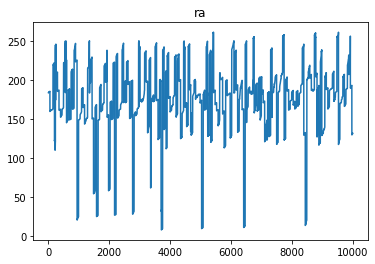

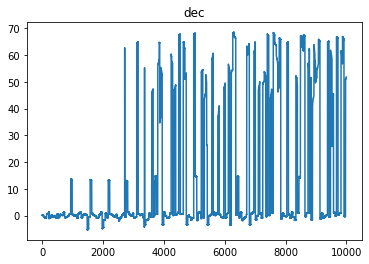

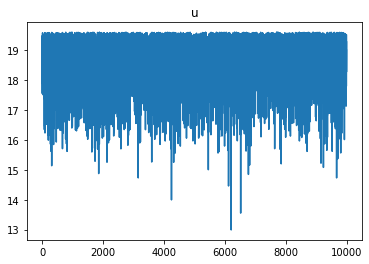

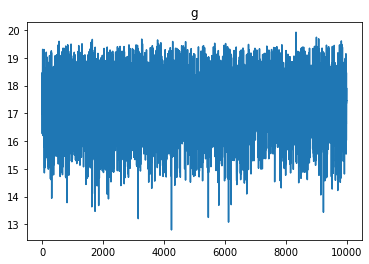

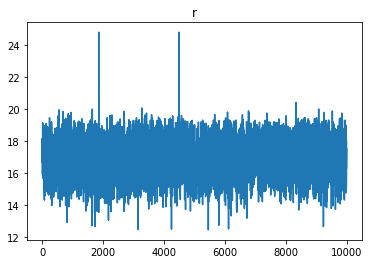

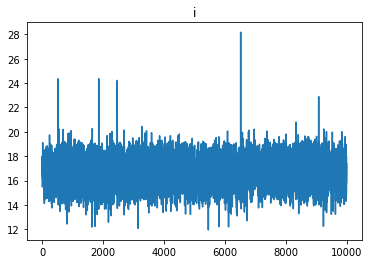

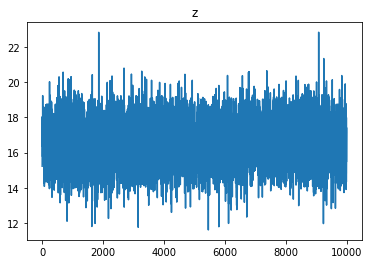

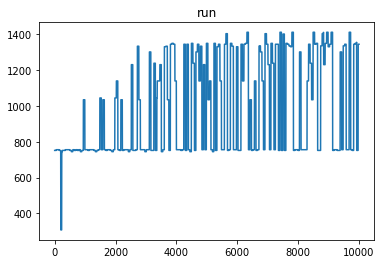

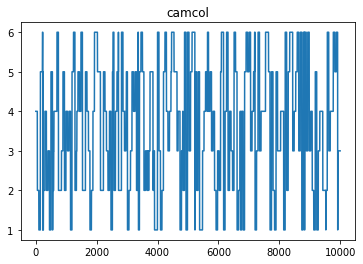

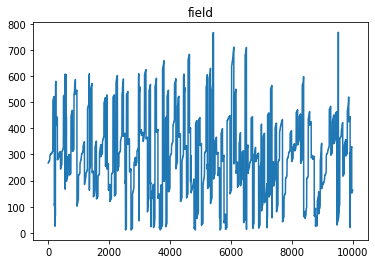

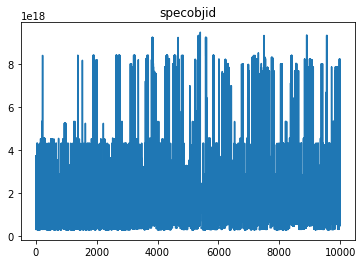

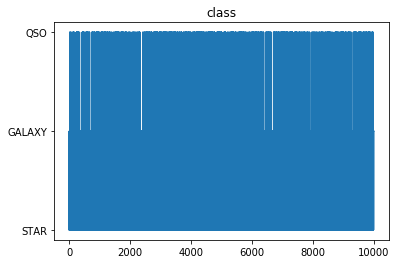

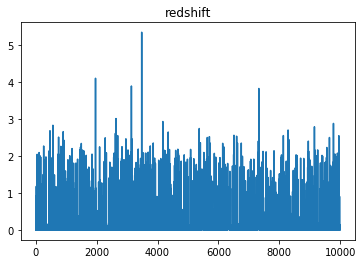

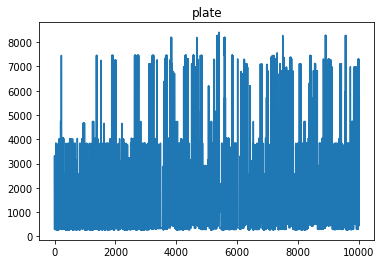

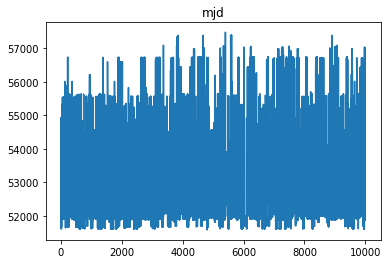

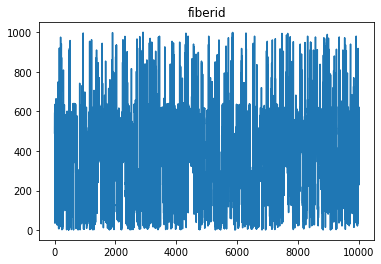

In [6]:
for column in data.columns:
    plt.figure()
    plt.title(column)
    plt.plot(data[column])

In [7]:
def color_big_values_red(val):
    color = 'red' if abs(val) > 0.3 else 'black'
    return 'color: %s' % color

In [8]:
data.corr().style.applymap(color_big_values_red)

,ra,dec,u,g,r,i,z,run,camcol,field,specobjid,redshift,plate,mjd,fiberid
ra,1,0.00359605,0.0312376,0.0439086,0.0471029,0.0457311,0.0429496,-0.0927406,-0.00629383,0.5947,-0.0953271,0.0303074,-0.0953293,-0.0868873,0.0574848
dec,0.00359605,1,0.0352793,0.0618747,0.063404,0.0582919,0.0568703,0.778385,0.114614,-0.131471,0.0883453,0.0670208,0.0883415,0.0661466,0.155012
u,0.0312376,0.0352793,1,0.849232,0.692379,0.60263,0.551483,0.0382291,0.00994467,0.00854788,-0.129429,0.163741,-0.12943,-0.168793,0.0113011
g,0.0439086,0.0618747,0.849232,1,0.958106,0.907419,0.879622,0.0584463,0.010223,0.0146511,-0.0549791,0.407576,-0.0549808,-0.0927716,0.0471874
r,0.0471029,0.063404,0.692379,0.958106,1,0.977672,0.969197,0.0572606,0.0107473,0.0171329,0.0197883,0.44108,0.0197867,-0.00934451,0.0610814
i,0.0457311,0.0582919,0.60263,0.907419,0.977672,1,0.981507,0.0497648,0.0134608,0.0197815,0.0729599,0.43145,0.0729584,0.0508962,0.0699774
z,0.0429496,0.0568703,0.551483,0.879622,0.969197,0.981507,1,0.0482523,0.0109298,0.0182484,0.112398,0.424034,0.112397,0.0956584,0.06798
run,-0.0927406,0.778385,0.0382291,0.0584463,0.0572606,0.0497648,0.0482523,1,0.151814,-0.463898,0.0936044,0.059056,0.0936011,0.0703543,0.138566
camcol,-0.00629383,0.114614,0.00994467,0.010223,0.0107473,0.0134608,0.0109298,0.151814,1,-0.0679205,0.0408094,0.00683354,0.0407946,0.026284,0.535629
field,0.5947,-0.131471,0.00854788,0.0146511,0.0171329,0.0197815,0.0182484,-0.463898,-0.0679205,1,-0.0937238,0.0154136,-0.0937232,-0.086558,-0.0404929


Можно заметить, что данные в частотных каналах имеют близкий к единице коэффициент корреляции, особенно в соседних каналах. Это и не удивительно, так как спектр излучения объектов, в основном, непрерывный. Это не очень хорошо с точки зрения data science, так как независимые признаки несли бы в себе больше информации.

Можно обнаружить высокие коэффициенты корелляции между колонками с данными об экспериментах, например, `plate` и `mjd` - это означает, что оптические системы меняли по временному графику. Или, например, корелляция параметров `run` и `dec` несет в себе информацию о том, в какой последовательности телескоп сканировал участки неба - это интересно подметить, но нам эти знания, скорее всего, не пригодятся. 

Также большой коэффициент (0.78) между колонками `dec` и `camcol` - это объясняется особенностями построения телескопа.

Интересно подумать, почему с ростом интенсивности растет величина красного смещения (корелляция redshift и z $\approx$ 0.4) - возможно, существует физическое объяснение, например, потому что в большинстве случаев максимум спектра излучения лежит в интервале частот, не снимаемых телескопом, и допплеровское смещение сдвигает этот максимум в видимый диапазон. Но утверждать этого наверняка, основываясь на имеющихся данных, нельзя. 

In [9]:
print(np.mean(data.values == data.dropna().values))

1.0


1.0 означает, что пропущенных значений нет

*Обработка категориальных признаков*

In [10]:
data.at[data['class'] == 'STAR', 'class'] = 0
data.at[data['class'] == 'GALAXY', 'class'] = 1
data.at[data['class'] == 'QSO', 'class'] = 2
data['class'].describe()

count    10000.000000
mean         0.669800
std          0.625465
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: class, dtype: float64

*Нормализация*

Приведем все поля, кроме поля `class`, к одним масштабам изменения

In [11]:
print(data.describe())
for col in [col for col in data.columns if col != 'class']:
    data[col] -= np.mean(data[col].values)
    data[col] /= np.std(data[col].values)
print(data.describe())

                 ra           dec             u             g             r  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     175.529987     14.836148     18.619355     17.371931     16.840963   
std       47.783439     25.212207      0.828656      0.945457      1.067764   
min        8.235100     -5.382632     12.988970     12.799550     12.431600   
25%      157.370946     -0.539035     18.178035     16.815100     16.173333   
50%      180.394514      0.404166     18.853095     17.495135     16.858770   
75%      201.547279     35.649397     19.259232     18.010145     17.512675   
max      260.884382     68.542265     19.599900     19.918970     24.802040   

                  i             z           run        camcol         field  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      16.583579     16.422833    981.034800      3.648700    302.380100   
std        1.141805      1.203188    273.305024    

При такой нормализации значения `min`, `max` и квантили оказались порядка единицы - это хорошо

*Классификатор*

In [12]:
X = data.drop('class', axis = 1).values
y = data['class'].values
print(X.shape, y.shape)

(10000, 15) (10000,)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape)

(7000, 15) (3000, 15)


In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [15]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)

In [16]:
print(err_test)

0.10166666666666667


Сработало!

In [17]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[1036  180    1]
 [  75 1420    2]
 [  18   29  239]]


-- Можно отметить, что квазары достаточно хорошо отделяются от звезд и галактик

Запустим подбор параметров методом GridSearch

In [18]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.09742857142857142 3


Попробуем посмотреть, как изменится точность, если сбалансировать тренировочную выборку по классам, выкинув часть звезд и галактик

In [19]:
X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
y_star = y_train[np.squeeze(np.argwhere(y_train==0))]
X_star = X_train[np.squeeze(np.argwhere(y_train==0))]
y_galaxy = y_train[np.squeeze(np.argwhere(y_train==1))]
X_galaxy = X_train[np.squeeze(np.argwhere(y_train==1))]
y_qso = y_train[np.squeeze(np.argwhere(y_train==2))]
X_qso = X_train[np.squeeze(np.argwhere(y_train==2))]
print(X_star.shape, X_galaxy.shape, X_qso.shape)
X_star = X_star[:len(X_star)//5]
y_star = y_star[:len(y_star)//5]
X_galaxy = X_galaxy[:len(X_galaxy)//6]
y_galaxy = y_galaxy[:len(y_galaxy)//6]
print(X_star.shape, X_galaxy.shape, X_qso.shape)

(2935, 15) (3501, 15) (564, 15)
(587, 15) (583, 15) (564, 15)


In [20]:
X_train2 = np.concatenate((X_star, X_galaxy, X_qso), axis = 0)
y_train2 = np.concatenate((y_star, y_galaxy, y_qso), axis = 0)
X_train2, y_train2 = sklearn.utils.shuffle(X_train2, y_train2)

print(X_train2.shape, y_train2.shape)

(1734, 15) (1734,)


In [21]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train2, y_train2)
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
print(err_test)

0.117


Ошибка ухудшилась, потому что стало меньше примеров в выборе - это особенность метода knn. В данном случае такой прием не подходит.

Попробуем другие методы

In [22]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.038 0.04533333333333334


In [23]:
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC(gamma='auto')
grid = GridSearchCV(svc, cv=3, param_grid = {'C': Cs, 'gamma': gamma_array}, verbose=10, n_jobs = -1)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C, grid.best_estimator_.gamma)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

0.012428571428571455 10000.0 0.001


In [24]:
print(grid.best_estimator_)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [25]:
svc = SVC(C = grid.best_estimator_.C, gamma  = grid.best_estimator_.gamma)
svc.fit(X_train, y_train)
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_test)

0.011333333333333334


Метод C-Support Vector Classification работает на порядок лучше!

In [26]:
svc = SVC(C = grid.best_estimator_.C, gamma  = grid.best_estimator_.gamma)
svc.fit(X_train2, y_train2)
err_test  = np.mean(y_test  != svc.predict(X_test))
print(err_test)

0.018


Прием с выкидыванием "лишних" примеров здесь тоже не работает

In [27]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0 0.009333333333333334


Почти идеально!

Однако ошибка на train очень маленькая, это оверфит. Нужно уменьшить количество деревьев в лесу - это обобщит алгоритм.

In [28]:
rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)



0.0017142857142857142 0.011


 -- Почти ничего не изменилось (но зато алгоритм ускорился и упростился)

In [29]:
print(confusion_matrix(y_test, rf.predict(X_test)))

[[1215    2    0]
 [   8 1484    5]
 [   0   18  268]]


-- Случайному лесу, в отличие от knn, сложнее отличать квазары от галактик

In [30]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
feature_names = [col for col in data.columns if col != 'class']
for f in range(X_train.shape[1]):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))   

Feature ranking:
 1. feature 'redshift' (0.584429)
 2. feature 'plate' (0.096381)
 3. feature '    z' (0.057826)
 4. feature '    i' (0.052608)
 5. feature 'specobjid' (0.050592)
 6. feature '    r' (0.043245)
 7. feature '  mjd' (0.033683)
 8. feature '    g' (0.033465)
 9. feature '    u' (0.025283)
10. feature 'fiberid' (0.007153)
11. feature '  dec' (0.004056)
12. feature 'field' (0.003919)
13. feature '   ra' (0.003397)
14. feature '  run' (0.002151)
15. feature 'camcol' (0.001812)


Как и можно было предположить изначально, в основном классификатор использует признаки "красное смещение" и интенсивности в частотных каналах. При этом для него почти неважно направление излучения ("dec" и "ra"), но при этом имеется небольшая зависимость от даты наблюдения - это плохо (может быть, обсерватория специально снимала только квазары в какой-то определенный день). Возможно, чтобы получить более "честный" результат, эти параметры необходимо отбросить

In [31]:
X = np.stack((data['redshift'].values,data['u'].values, data['i'].values, data['r'].values, data['z'].values, data['g'].values), axis = 1)
y = data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape)

(7000, 6) (3000, 6)


In [32]:
rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0012857142857142856 0.008666666666666666


Результат улучшился! При этом он имеет более прозрачный физический смысл.

In [33]:
print(confusion_matrix(y_test, rf.predict(X_test)))

[[1216    1    0]
 [   8 1486    3]
 [   0   14  272]]


# Вывод

Мы научились с точностью 99% разделять астрономические объекты на классы "звезда", "галактика" и "квазар", используя данные с телескопа. Наилучшую точность показал алгоритм RandomForest. Оказалось, что выкидывание лишних данных может улучшить алгоритм. Мы попробовали сбалансировать тренировочную выборку, но это не увеличило точность.

# Homework 2 (November 18)

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix

%matplotlib inline

data = pd.read_csv('./Skyserver_SQL2_27_2018 6_51_39 PM.csv')

# нормировать, инче данные, имеющие большой масштаб изменения, будут иметь больший вклад в функцию ошибок регрессии
for col in [col for col in data.columns if col != 'class']: 
    data[col] -= np.mean(data[col].values)
    if np.std(data[col].values) == 0: # эти значения не нужны в любом случае
        data = data.drop(col, axis = 1)
    else:
        data[col] /= np.std(data[col].values)
data.at[data['class'] == 'STAR', 'class'] = 0
data.at[data['class'] == 'GALAXY', 'class'] = 1
data.at[data['class'] == 'QSO', 'class'] = 2

X = data.drop('class', axis = 1).values
y = data['class'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


In [35]:
data.describe()

,ra,dec,u,g,r,i,z,run,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-2.465805e-16,-2.000622e-17,4.284162e-15,-1.235934e-15,3.275158e-17,-2.770895e-15,2.951195e-16,3.030451e-14,9.546419e-15,-7.172041e-17,-1.360023e-17,0.669800,7.344542e-17,2.662315e-17,-1.936229e-15,4.618528e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.625465,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.501281e+00,-8.019842e-01,-6.794939e+00,-4.836401e+00,-4.129735e+00,-4.060765e+00,-3.999927e+00,-2.462701e+00,-1.589761e+00,-1.792340e+00,-6.680794e-01,0.000000,-3.803474e-01,-6.680795e-01,-9.036833e-01,-1.706690e+00
25%,-3.800469e-01,-6.098614e-01,-5.326003e-01,-5.889842e-01,-6.252917e-01,-6.392605e-01,-6.687137e-01,-8.380609e-01,-9.895566e-01,-7.281809e-01,-6.485418e-01,0.000000,-3.695000e-01,-6.485121e-01,-6.905900e-01,-8.062492e-01
50%,1.018087e-01,-5.724490e-01,2.820849e-01,1.303176e-01,1.667744e-02,-2.504428e-02,-2.733555e-02,-8.234245e-01,2.108517e-01,-2.079171e-02,-5.702194e-01,1.000000,-2.601513e-01,-5.702425e-01,-6.263973e-01,-1.003161e-02
75%,5.445107e-01,8.255640e-01,7.722253e-01,6.750654e-01,6.291138e-01,5.911733e-01,5.972884e-01,1.280557e+00,8.110559e-01,6.865975e-01,6.138735e-01,1.000000,-1.315668e-01,6.138650e-01,1.008862e+00,7.607361e-01
max,1.786365e+00,2.130270e+00,1.183354e+00,2.694110e+00,7.456210e+00,1.015640e+01,5.327968e+00,1.576944e+00,1.411260e+00,2.864126e+00,3.884908e+00,2.000000,1.340210e+01,3.884976e+00,3.002807e+00,3.136058e+00


Baseline

In [36]:
rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test_baseline  = np.mean(y_test  != rf.predict(X_test))

print('Train error: \n', err_train, ' \nTest error: \n', err_test_baseline)

Train error: 
 0.001142857142857143  
Test error: 
 0.011666666666666667


Визуализация

Variances: 
 [0.30675716 0.2125822 ]


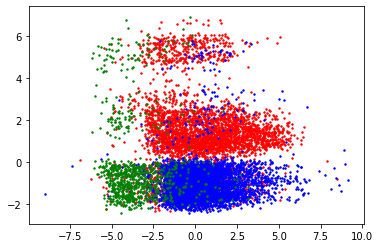

In [37]:
pca = sklearn.decomposition.PCA(n_components = 2)
X_view = pca.fit_transform(X)
print('Variances: \n', pca.explained_variance_ratio_)
plt.scatter(X_view[y == 0, 0], X_view[y == 0, 1], color = 'red', s = 2)
plt.scatter(X_view[y == 1, 0], X_view[y == 1, 1], color = 'blue', s = 2)
plt.scatter(X_view[y == 2, 0], X_view[y == 2, 1], color = 'green', s = 2)


 - на этой плоскости можно легко увидеть три кластера, отвечающих каждому классу
 

Как было выяснено выше, в данных имеется несколько коррелированных столбцов, имеющих очевидный физический смысл и представляющих доминирующую важность для классификатора (назовем их physical components). Посмотрим, как выглядят они после одномерного и двумерного преобразования:

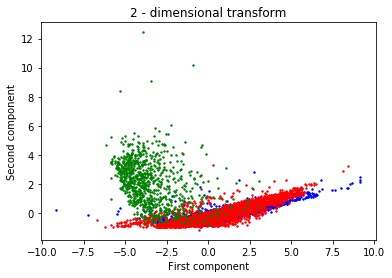

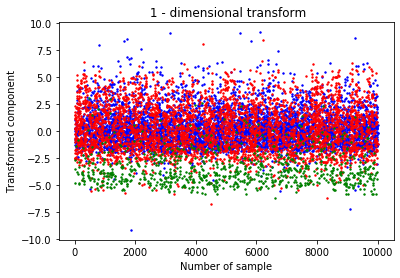

In [38]:
X_small = np.stack((data['redshift'].values,data['u'].values, data['i'].values, data['r'].values, data['z'].values, data['g'].values), axis = 1)
pca = sklearn.decomposition.PCA(n_components = 2)
X_view = pca.fit_transform(X_small)
plt.title('2 - dimensional transform')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.scatter(X_view[y == 1, 0], X_view[y == 1, 1], color = 'blue', s = 2)
plt.scatter(X_view[y == 0, 0], X_view[y == 0, 1], color = 'red', s = 2)
plt.scatter(X_view[y == 2, 0], X_view[y == 2, 1], color = 'green', s = 2)
plt.show()

pca = sklearn.decomposition.PCA(n_components = 1)
X_view = pca.fit_transform(X_small)
t = np.linspace(0, X.shape[0], X.shape[0])
plt.title(' 1 - dimensional transform')
plt.xlabel('Number of sample')
plt.ylabel('Transformed component')
plt.scatter(t[y == 1], X_view[y == 1, 0], color = 'blue', s = 2)
plt.scatter(t[y == 0], X_view[y == 0, 0], color = 'red', s = 2)
plt.scatter(t[y == 2], X_view[y == 2, 0], color = 'green', s = 2)
plt.show()

- На двумерной плоскости видно, что квазары расположены вдоль вектора, ортогонального вектору, вдоль которого расположены звезды и галактикы, и, как следствие, квазары легко кластеризуются на одномерной картинке

- Очень трудно разделить звезды и галактики как на двумерной, так и на одномерной картинах

Классификатор на преобразованных данных:

In [39]:
pca = sklearn.decomposition.PCA(n_components = 2)
X_view = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_view, y, test_size = 0.3, random_state = 42)
rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)
err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print('Train error: \n', err_train, ' \nTest error: \n', err_test)

print('Confusion matrix: \n', confusion_matrix(y_test, rf.predict(X_test)))

Train error: 
 0.016  
Test error: 
 0.18966666666666668
Confusion matrix: 
 [[ 919  269   29]
 [ 165 1318   14]
 [  57   35  194]]


In [40]:
pca = sklearn.decomposition.PCA(n_components = 2)
X_view = pca.fit_transform(X_small)
X_train, X_test, y_train, y_test = train_test_split(X_view, y, test_size = 0.3, random_state = 42)
rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)
err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print('Train error (physical components): \n', err_train, ' \nTest error (physical components): \n', err_test)
print(confusion_matrix(y_test, rf.predict(X_test)))

Train error (physical components): 
 0.02157142857142857  
Test error (physical components): 
 0.31433333333333335
[[ 789  419    9]
 [ 482 1010    5]
 [  17   11  258]]


Действительно, как видно из confusion matrix, ошибка разделения звезд и галактик велика. Точность на двух компонентах существенно ниже результата baseline.

Выберем такое число главных компонент, чтобы объясненная дисперсия $\alpha$ была не меньше 95%

In [41]:
alpha = 0.95

pca = sklearn.decomposition.PCA(n_components = X.shape[1])
pca.fit(X)
for i in range(len(pca.explained_variance_ratio_)):
    if np.sum(pca.explained_variance_ratio_[:X.shape[1] - i]) > alpha:
        continue
    else:
        break
X_transformed = pca.transform(X)[:, :i]
print('n_components: ', X.shape[1] - i, ', explained variance: ', np.sum(pca.explained_variance_ratio_[:i])) 
X_transformed = X_transformed[:, :i]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.3, random_state = 42)

rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print('Train error: \n', err_train, ' \nTest error: \n', err_test)

n_components:  7 , explained variance:  0.9585944418979688
Train error: 
 0.004714285714285714  
Test error: 
 0.097


Теперь построим график зависимости ошибки от числа компонент

Difference with baseline at n_components = max:  0.028999999999999998


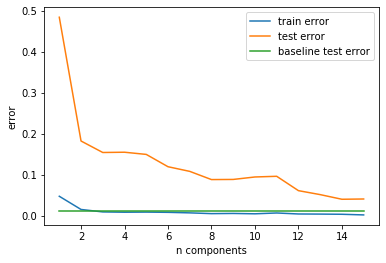

In [42]:
train = []
test = []
components = []
for i in range(1, X.shape[1]+1):
    pca = sklearn.decomposition.PCA(n_components = i)
    X_transformed = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.3, random_state = 42)
    rf = ensemble.RandomForestClassifier(n_estimators = 10)
    rf.fit(X_train, y_train)
    err_train = np.mean(y_train != rf.predict(X_train))
    err_test  = np.mean(y_test  != rf.predict(X_test))
    train.append(err_train)
    test.append(err_test)
    components.append(i)
plt.xlabel('n components')
plt.ylabel('error')
plt.plot(components, train, label = 'train error')
plt.plot(components, test, label = 'test error')
plt.plot(components, [err_test_baseline]*len(components), label = 'baseline test error')
plt.legend()
print('Difference with baseline at n_components = max: ', test[-1] - err_test_baseline)

Из графика видно, что ошибка классификации методом случайного леса равномерно убывает с увеличением числа компонент. При этом методом blind source separation не удается извлечь тот набор physical components, которые важны для классификатора. В данном случае это можно объяснить большим количеством ненужных коррелированных компонент, которые мешают выделению physical components. При этом нужно обратить внимание, что из-за большой корреляции ненужных компонент с physical components, даже при n_components = 15 ошибка не равна ошибке baseline.

Тем не менее, PCA успешно можно использовать для тех задач, где нужно выделить компоненты, не имея доступа к ответам обучающей выборки - например, для преобразования цветов в некоторых задачах компьютерного зрения, или для упрощения задач поиска многомерного глобального минимума (например, в астрофизике).

Difference with baseline at n_components = max:  -0.00033333333333333305


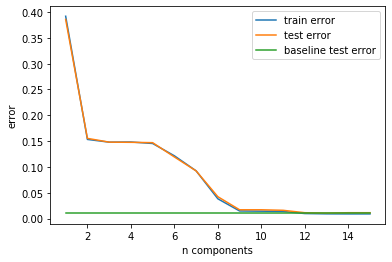

In [43]:
from sklearn.svm import SVC
train = []
test = []
components = []
for i in range(1, X.shape[1]+1):
    pca = sklearn.decomposition.PCA(n_components = i)
    X_transformed = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.3, random_state = 42)
    svc = SVC(gamma=0.001, C = 10000) # best grid search parameters from high above
    svc.fit(X_train, y_train)
    err_train = np.mean(y_train != svc.predict(X_train))
    err_test  = np.mean(y_test  != svc.predict(X_test))
    train.append(err_train)
    test.append(err_test)
    components.append(i)
plt.xlabel('n components')
plt.ylabel('error')
plt.plot(components, train, label = 'train error')
plt.plot(components, test, label = 'test error')
plt.plot(components, [err_test_baseline]*len(components), label = 'baseline test error')
plt.legend()
print('Difference with baseline at n_components = max: ', test[-1] - err_test_baseline)


Постфактум можно сказать, что лучшее значение количества компонент для случайного леса - 15 (все компоненты), а для классификатора SVM - 9 или 12 (такое количество компонент, что при дальнейшем его увеличении ошибка меняется незначительно), что отличается от значения, полученного по правилу "взять количество компонент, описывающих 95% дисперсии"

# Homework 3 (December 16)

Обучить полносвязную нейронную сеть

In [44]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
data = pd.read_csv('./Skyserver_SQL2_27_2018 6_51_39 PM.csv')
# нормировать, иначе данные, имеющие большой масштаб изменения, будут иметь больший вклад в функцию ошибок регрессии
for col in [col for col in data.columns if col != 'class']: 
    data[col] -= np.mean(data[col].values)
    if np.std(data[col].values) == 0: # эти значения не нужны в любом случае
        data = data.drop(col, axis = 1)
    else:
        data[col] /= np.std(data[col].values)
data.at[data['class'] == 'STAR', 'class'] = 0
data.at[data['class'] == 'GALAXY', 'class'] = 1
data.at[data['class'] == 'QSO', 'class'] = 2
X = data.drop('class', axis = 1).values
y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 15) (3000, 15) (7000,) (3000,)


Baseline

In [45]:
rf = ensemble.RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)
print('Error test', np.mean(y_test  != rf.predict(X_test)), 'score', rf.score(X_test, y_test))

Error test 0.011333333333333334 score 0.9886666666666667


Подбираем оптимальные параметры слоев

/home/neurosense/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


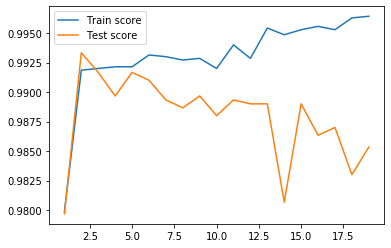

In [46]:
test_scores =[]
train_scores =[]
for i in tqdm(range(1, 20)):
    mlp_model = MLPClassifier(alpha = 0, hidden_layer_sizes = (i,), solver = 'lbfgs', 
                              activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)
    train_scores.append(mlp_model.score(X_train, y_train))
    test_scores.append(mlp_model.score(X_test, y_test))
plt.plot(range(1, 20), train_scores, label = 'Train score')
plt.plot(range(1, 20), test_scores, label = 'Test score')
plt.legend()

/home/neurosense/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


1e-05 0.9923333333333333
2.1544346900318823e-05 0.9923333333333333
4.641588833612782e-05 0.9926666666666667
0.0001 0.9913333333333333
0.00021544346900318823 0.9923333333333333
0.00046415888336127773 0.9923333333333333
0.001 0.9923333333333333
0.002154434690031882 0.9923333333333333
0.004641588833612777 0.9923333333333333
0.01 0.9916666666666667



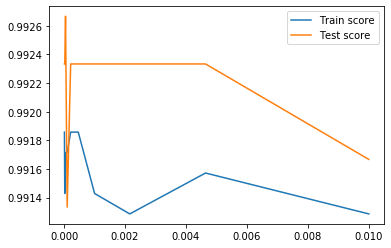

In [47]:
test_scores =[]
train_scores =[]

for alpha in tqdm(np.logspace(-5, -2, 10)):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (2,), solver = 'lbfgs', 
                              activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)
    train_scores.append(mlp_model.score(X_train, y_train))
    test_scores.append(mlp_model.score(X_test, y_test))
    print(alpha, test_scores[-1])
plt.plot(np.logspace(-5, -2, 10), train_scores, label = 'Train score')
plt.plot(np.logspace(-5, -2, 10), test_scores, label = 'Test score')
plt.legend()

In [48]:
alpha_opt = 0
i_opt = 0
j_opt = 0
best_score = 0
for act in tqdm(['logistic', 'relu','tanh']):
    for alpha in np.logspace(-5, -3, 3):
        for i in range(1,7):
            for j in range(1, 7):
                mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (i,j), solver = 'lbfgs', 
                                          activation = 'logistic', random_state = 42)
                mlp_model.fit(X_train, y_train)
                test_score = mlp_model.score(X_test, y_test)
                if test_score >= best_score:
                    best_score = test_score
                    i_opt = i
                    j_opt = j
                    print('New best score', best_score, i_opt, j_opt, alpha, act)


/home/neurosense/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


New best score 0.9816666666666667 1 1 1e-05 logistic
New best score 0.986 1 2 1e-05 logistic
New best score 0.9913333333333333 2 2 1e-05 logistic
New best score 0.9926666666666667 2 4 1e-05 logistic
New best score 0.9933333333333333 3 3 1e-05 logistic
New best score 0.9933333333333333 3 3 1e-05 relu
New best score 0.9933333333333333 3 3 1e-05 tanh



In [49]:
alpha_opt = 1e-5
i_opt = 0
j_opt = 0
s_opt = 0
best_score = 0
for s in tqdm(range(1,5)):
    for i in range(1,5):
        for j in range(1, 5):
            mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (i,j, s), solver = 'lbfgs', 
                                      activation = 'logistic', random_state = 42)
            mlp_model.fit(X_train, y_train)
            test_score = mlp_model.score(X_test, y_test)
            if test_score > best_score:
                best_score = test_score
                i_opt = i
                j_opt = j
                s_opt = s
                print('New best score', best_score, i_opt, j_opt, s_opt)

/home/neurosense/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


New best score 0.9703333333333334 1 1 1
New best score 0.9846666666666667 1 2 1
New best score 0.9856666666666667 1 4 2
New best score 0.991 4 1 2
New best score 0.9926666666666667 3 3 3



[[1215    9    0]
 [   2 1482   14]
 [   0    6  272]]


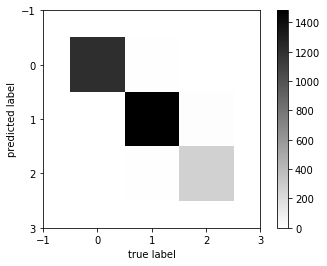

In [50]:
best_mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (i_opt,j_opt), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
y_test_pred = mlp_model.predict(X_test)
M = confusion_matrix(y_test_pred, y_test)
print(M)
plt.imshow(M)
plt.set_cmap('binary')
plt.xticks(range(-1, 4))
plt.yticks(range(-1, 4))

plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()

Методом перебора гиперпараметров мы выяснили, что из рассмотренных моделей лучшей является четырехсойный перцептрон MLPClassifier(alpha = 1e-5, hidden_layer_sizes = (3,6), solver = 'lbfgs', activation = 'logistic'). В предыдущем домашнем задании было выяснено, что в данной задаче при сокращении размерности пространства ошибка неизбежно растет. Попробуем проделать то же самое для лучшего MLP классификатора, выбрав количество компонент, обоснующее 95% вариации (не факт, что именно этот классификатор останется лучшим для преобразованных данных - это жадное предположение).

In [51]:
for i in range(X.shape[1]):
    pca = sklearn.decomposition.PCA(n_components = i+1)
    pca.fit(X)
    X_transformed = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.3, random_state = 42)
    best_mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (i_opt,j_opt), solver = 'lbfgs', 
                              activation = 'logistic', random_state = 42)
    best_mlp_model.fit(X_train, y_train)
    test_score = best_mlp_model.score(X_test, y_test)
    train_score = best_mlp_model.score(X_train, y_train)

    print('Components:', i+1, 'Train score:', train_score, ' Test score:', test_score)

Components: 1 Train score: 0.6154285714285714  Test score: 0.6263333333333333
Components: 2 Train score: 0.8545714285714285  Test score: 0.8553333333333333
Components: 3 Train score: 0.8594285714285714  Test score: 0.8596666666666667
Components: 4 Train score: 0.8564285714285714  Test score: 0.8606666666666667
Components: 5 Train score: 0.8644285714285714  Test score: 0.8616666666666667
Components: 6 Train score: 0.8825714285714286  Test score: 0.8863333333333333
Components: 7 Train score: 0.904  Test score: 0.9106666666666666
Components: 8 Train score: 0.9524285714285714  Test score: 0.9463333333333334
Components: 9 Train score: 0.984  Test score: 0.9823333333333333
Components: 10 Train score: 0.985  Test score: 0.9826666666666667
Components: 11 Train score: 0.9858571428571429  Test score: 0.9833333333333333
Components: 12 Train score: 0.9894285714285714  Test score: 0.9883333333333333
Components: 13 Train score: 0.9921428571428571  Test score: 0.9916666666666667
Components: 14 Train 

# Вывод
Мы построили неглубокий MLP-классификатор и перебрали возможные значения гиперпараметров, а также попробовали применить преобразование PCA над входными данными. MLP-классификатор побил предыдущий рекорд на валидационной выборке, полученный методом случайного леса (точность на тестовых данных 0.9937 против 0.988).

# Homework 4 (February, 20)

Обучить **Random Forest** и **Gradient Boosted Trees**. Построить зависимость ошибки train, test, oob от количества деревьев. Сделать выводы.

In [52]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
data = pd.read_csv('./Skyserver_SQL2_27_2018 6_51_39 PM.csv')
# нормировать, иначе данные, имеющие большой масштаб изменения, будут иметь больший вклад в функцию ошибок регрессии
for col in [col for col in data.columns if col != 'class']: 
    data[col] -= np.mean(data[col].values)
    if np.std(data[col].values) == 0: # эти значения не нужны в любом случае
        data = data.drop(col, axis = 1)
    else:
        data[col] /= np.std(data[col].values)
data.at[data['class'] == 'STAR', 'class'] = 0
data.at[data['class'] == 'GALAXY', 'class'] = 1
data.at[data['class'] == 'QSO', 'class'] = 2
X = data.drop('class', axis = 1).values
y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 15) (3000, 15) (7000,) (3000,)


In [53]:
warnings.filterwarnings("ignore")
n_estimators = np.linspace(1, 20, 20).astype(int)
train_accs = []
test_accs = []
oob_scores = []
for n in tqdm(n_estimators):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n, oob_score = True, n_jobs = -1,random_state = 42)
    clf.fit(X_train, y_train)
    train_accs.append(clf.score(X_train, y_train))
    test_accs.append(clf.score(X_test, y_test))
    oob_scores.append(clf.oob_score_)
print('Best test accuracy: ', np.max(test_accs), 'Best oob accuracy:',  np.max(oob_scores),
      'Best train accuracy: ', np.max(train_accs))
plt.plot(n_estimators, train_accs, label = 'Train accuracy')
plt.plot(n_estimators, test_accs, label = 'Test accuracy')
plt.plot(n_estimators, oob_scores, label = 'OOB score')
plt.xlabel('N estimators')
plt.ylabel('Accuracy')
plt.legend()

ValueError: Stop argument for islice() must be None or an integer: 0 <= x <= sys.maxsize.

In [ ]:
train_accs = []
test_accs = []
for n in tqdm(n_estimators):
    clf = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.17, n_estimators=20, subsample=1.0, 
                                                  criterion='friedman_mse')    
    clf.fit(X_train, y_train)
    train_accs.append(clf.score(X_train, y_train))
    test_accs.append(clf.score(X_test, y_test))
print('Best test accuracy: ', np.max(test_accs))
plt.plot(n_estimators, train_accs, label = 'Train accuracy')
plt.plot(n_estimators, test_accs, label = 'Test accuracy')
plt.xlabel('N estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

train_accs = []
test_accs = []
for n in tqdm(n_estimators):
    clf = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.17, n_estimators=20, subsample=1.0, 
                                                  criterion='mse')    
    clf.fit(X_train, y_train)
    train_accs.append(clf.score(X_train, y_train))
    test_accs.append(clf.score(X_test, y_test))
print('Best test accuracy: ', np.max(test_accs))
plt.plot(n_estimators, train_accs, label = 'Train accuracy')
plt.plot(n_estimators, test_accs, label = 'Test accuracy')
plt.xlabel('N estimators')
plt.ylabel('Accuracy')
plt.legend()

# Вывод:

* Переобучение не наблюдается. Оба ансамбля деревьев демонстрируют высокую точность как на train-выборке, так и на test.

* OOB score растет достаточно медленно с количеством деревьев по сравнению с train и test accuracies. В документации sklearn рекомендутся выбрать количество деревьев, на котором OOB-точность стабилизируется - приблизительно 20 деревьев. В данном случае это не очень важно, так как точность на тестовой выборке ведет себя стабильно с изменением параметров.

* Ни алгоритм Random Forest, ни GradientBoostingClassifier не смогли побить рекорд тестовой точности 0.9937, полученной полносвязной нейронной сетью.